In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

from K_mean_cluster import run_clustering
from utils.PCA import perform_PCA, prep_PCA_data
from utils.prepData import prep_data
import plotly.express as px


In [2]:
BA_US_knn_text = pd.read_csv('../../../knnData/BA_US_knn_text.csv')

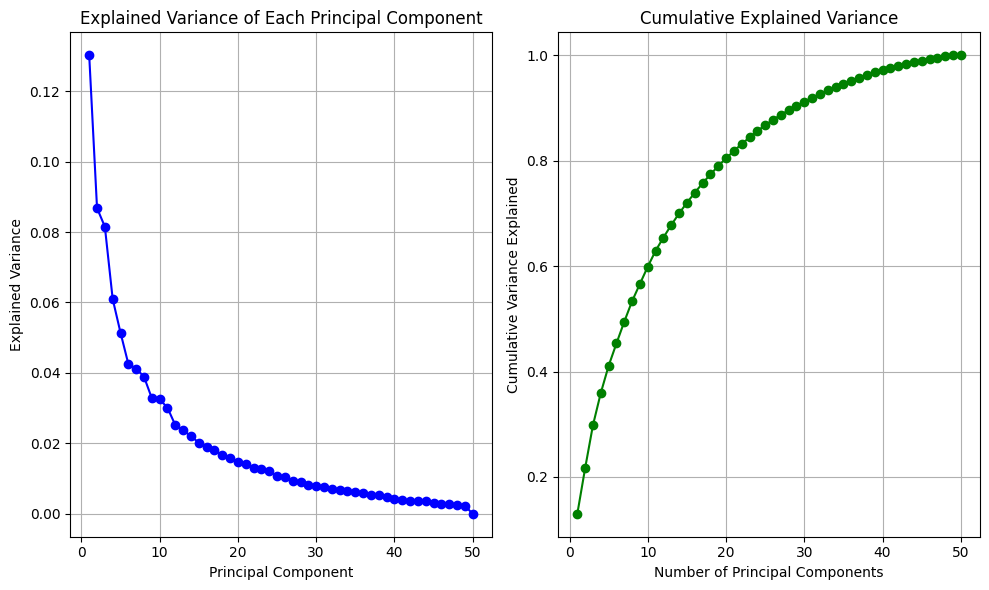

Top features for PC1:
American IPA_avg_taste                0.083549
American IPA_avg_overall              0.081084
American Pale Ale (APA)_avg_palate    0.080241
American Pale Ale (APA)_avg_taste     0.080232
American Brown Ale_avg_palate         0.079230
                                        ...   
Faro_avg_taste                        0.000038
Tripel_normalised_review_count        0.000025
Sahti_avg_palate                      0.000021
Faro_std_per_style                    0.000000
Faro_avg_rating_per_style             0.000000
Name: PC1, Length: 824, dtype: float64

Top features for PC2:
English Barleywine_avg_aroma                                   0.088175
English Bitter_avg_palate                                      0.087581
Herbed / Spiced Beer_avg_palate                                0.085375
English Bitter_avg_appearance                                  0.085026
Cream Ale_avg_rating_per_style                                 0.084787
                                       

c:\Users\Enzo\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: ['Alaska', 'Arkansas', 'Connecticut', 'Maine', 'Massachusetts', 'Minnesota', 'New Hampshire', 'Rhode Island', 'South Dakota', 'Vermont']
Cluster 1: ['Delaware', 'Georgia', 'Illinois', 'Michigan', 'New York', 'North Carolina', 'South Carolina']
Cluster 2: ['Alabama', 'Arizona', 'California', 'Colorado', 'Florida', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'New Mexico', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Cluster 3: ['Utah']


In [3]:
run_clustering(BA_US_knn_text)

In [4]:
df_tot, states = prep_data(BA_US_knn_text)
df_clustering = prep_PCA_data(df_tot)
kmeans = KMeans(n_clusters=4, random_state=42) #we choose 5 clusters
df_pca_clusters = kmeans.fit_predict(df_clustering)
    
    #crush into 3D for visualisation
pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_clustering) 

    # Step 2: Create a DataFrame with the PCA components, clusters, and state labels
df_pca_3d_df = pd.DataFrame(df_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d_df['Cluster'] = df_pca_clusters  # Add the cluster labels to the DataFrame
df_pca_3d_df['State'] = states

    # Step 3: Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df_pca_3d_df, x='PC1', y='PC2', z='PC3', color='Cluster', 
                        title="3D PCA with Clusters", 
                        labels={'State': 'State'},
                        hover_data={'State': True, 'PC1': False, 'PC2': False, 'PC3': False, 'Cluster': False}) 

    # Show the plot
fig.show()

states_in_clusters = df_pca_3d_df.groupby('Cluster')['State'].apply(list)

    # Print the states in each cluster
for cluster, states in states_in_clusters.items():
    print(f"Cluster {cluster}: {states}")

c:\Users\Enzo\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Cluster 0: ['Maine']
Cluster 1: ['Alaska', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Georgia', 'Hawaii', 'Illinois', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin']
Cluster 2: ['Alabama', 'Arizona', 'Florida', 'Idaho', 'Indiana', 'Iowa', 'Nebraska', 'Nevada', 'North Dakota', 'Wyoming']
Cluster 3: ['Utah']
